# Building the model

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import pgmpy.inference
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, cross_val_score

#### Loading cleaned data

In [2]:
df = pd.read_csv('cleaned_data.csv', index_col='Unnamed: 0')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df['Pclass'] = df['Pclass'] - 1

#### Grouping Age

In [4]:
df.loc[df.Age < 15,'Age'] = 0
df.loc[(df.Age >= 15) & (df.Age < 30), 'Age'] = 1
df.loc[(df.Age >= 30) & (df.Age < 45), 'Age'] = 2
df.loc[df.Age >= 45, 'Age'] = 3

#### processing Embarked and Sex

In [5]:
# df.loc[df.Cabin.isnull(), 'Cabin'] = 0
# df.loc[df.Cabin.notnull(), 'Cabin'] = 1

In [6]:
df.loc[df.Sex == 'male', 'Sex'] = 0
df.loc[df.Sex == 'female', 'Sex'] = 1

In [7]:
df.loc[df.Sex == 'S', 'Embarked'] = 0
df.loc[df.Sex == 'C', 'Embarked'] = 1
df.loc[df.Sex == 'Q', 'Embarked'] = 1

#### Dropping the unused columns

In [8]:
to_drop = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'Fare']
final_df = df.drop(columns = to_drop, axis=1)

In [9]:
final_df.Age = final_df.Age.astype(int)
final_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,2,0,1,1,0,S
1,1,0,1,2,1,0,C
2,1,2,1,1,0,0,S
3,1,0,1,2,1,0,S
4,0,2,0,2,0,0,S
...,...,...,...,...,...,...,...
883,0,1,0,1,0,0,S
884,1,0,1,1,0,0,S
885,0,2,1,0,1,2,S
886,1,0,0,1,0,0,C


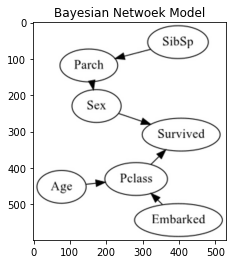

In [10]:
img = mpimg.imread('model.png')
imgplot = plt.imshow(img)
plt.title("Bayesian Netwoek Model")
plt.show()


In [11]:
final_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [12]:
model = BayesianModel([('SibSp', 'Parch'),
                       ('Parch', 'Sex'),
                       ('Sex', 'Survived'),
                       ('Pclass', 'Survived'),
                       ('Age', 'Pclass'),
                       ('Embarked', 'Pclass')
                       ])

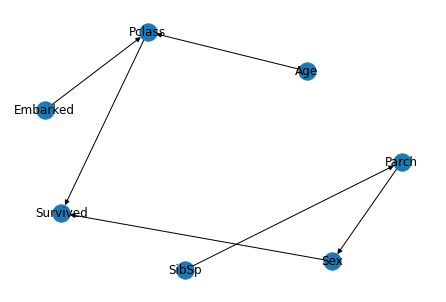

In [13]:
nx.draw(model, with_labels=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(final_df, final_df, test_size=0.2, random_state=44)


In [15]:
model.fit(X_train, estimator=BayesianEstimator, prior_type="BDeu")


In [16]:
test_data = X_test.drop(columns=['Survived'], axis=1)
y_pred = model.predict(test_data)

100%|██████████| 79/79 [00:03<00:00, 21.40it/s]


In [17]:
accuracy_score(y_pred['Survived'], X_test['Survived'])


0.7865168539325843

In [18]:
from pgmpy.inference import VariableElimination
model_infer = VariableElimination(model)
q = model_infer.query(variables=['Survived'], evidence={'Age': 1, 'Sex': 0})
print(q)

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 295.03it/s]

Eliminating: Embarked: 100%|██████████| 4/4 [00:00<00:00, 259.49it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.8257 |
+-------------+-----------------+
| Survived(1) |          0.1743 |
+-------------+-----------------+


#### k fold cross validation

In [21]:
scores = cross_validation(model, final_df, 10, target="Survived")


[     Survived  Pclass Sex  Age  SibSp  Parch Embarked
89          0       2   0    1      0      0        S
414         0       2   1    2      0      0        S
160         1       1   1    2      0      0        S
596         0       2   0    3      0      0        S
843         0       2   0    2      8      2        S
..        ...     ...  ..  ...    ...    ...      ...
355         1       0   1    1      0      1        S
169         0       0   0    3      0      0        S
298         1       0   1    3      0      1        C
102         0       2   0    2      0      0        S
534         1       1   1    0      0      2        S

[89 rows x 7 columns],      Survived  Pclass Sex  Age  SibSp  Parch Embarked
784         1       2   1    1      0      0        S
846         1       0   1    2      1      0        C
57          0       2   0    1      0      0        C
310         1       0   1    1      2      2        C
633         0       2   1    0      3      2        S
.. 

100%|██████████| 62/62 [00:00<00:00, 368.21it/s]


IndexError: index 6 is out of bounds for axis 0 with size 6

In [26]:
# scores

In [ ]:
# np.mean(scores)